In [5]:
# Getting all the waveform and alignment paths

from pathlib import Path

waveform_dir = Path().home() / "Desktop" / "Data" / "Librispeech/dev/audio"
alignment_dir = Path().home() / "Desktop" / "Data" / "Librispeech/dev/alignments_syllables"

waveform_paths = {p.stem: p for p in waveform_dir.rglob("*.flac")}
alignment_paths = {p.stem: p for p in alignment_dir.rglob("*.TextGrid")}

common_stems = sorted(waveform_paths.keys() & alignment_paths.keys())
waveform_paths = [waveform_paths[s] for s in common_stems]
alignment_paths = [alignment_paths[s] for s in common_stems]


In [6]:
# Processing a random example

import numpy as np
import textgrids

index = np.random.randint(len(waveform_paths))
waveform_path = waveform_paths[index]
alignment_path = alignment_paths[index]

tg = textgrids.TextGrid(str(alignment_path))
words = tg['words']
words = [interval.text for interval in words if interval.text.strip()]
print(f"Processing {waveform_path.name}, {" ".join(words)}")

Processing 2428-83705-0013.flac, it is from her action in that matter that my suspicion springs


In [13]:
# Functions for plotting and listening
import IPython.display as ipd
from pydub import AudioSegment
import torchaudio
import matplotlib.pyplot as plt

def listen_to_segmentation(waveform_path, peaks):
    audio = AudioSegment.from_file(waveform_path)
    segments = []

    for i in range(len(peaks) - 1):
        start_ms = int(peaks[i] * 20)  
        end_ms = int(peaks[i + 1] * 20)
        segment = audio[start_ms:end_ms]
        segments.append(segment)
    combined = AudioSegment.silent(duration=0)
    for segment in segments:
        combined += segment + AudioSegment.silent(duration=500)
    return ipd.Audio(combined.export(format="wav").read(), rate=16000)

def get_frame_num(time_sec):
    return np.floor(np.round((time_sec / 20 * 1000), 1) + 0.5).astype(np.int32) 

def plot_segmentation(
    waveform, 
    tg,
    peaks=None,
    norms=None,
    norms_smooth=None,
    ax=None,
    title=None
):
    tMel = torchaudio.transforms.MelSpectrogram(
        sample_rate=16000,
        n_fft=1024,
        win_length=400,
        hop_length=320,
        f_min=0,
        f_max=8000,
        n_mels=128,
        center=True,
    )
    n_mels = tMel.n_mels
    tDB = torchaudio.transforms.AmplitudeToDB(top_db=80)
    melspec = tDB(tMel(waveform.cpu()))  
    mels = melspec[0].numpy()
    

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 3))
    ax.imshow(mels, aspect="auto", origin="lower")
    ax.set_ylim(0, mels.shape[0])

    if title:
        ax.set_title(title)
    
    def x_coords(n):
        return [i + 0.5 for i in range(n)]

    def sec_to_frame(s):  
        return int(np.round(s * 50))
    
    if norms is not None:
        ax.plot(x_coords(len(norms)), 10 * np.asarray(norms) + 64, color="w", linewidth=1.0, alpha=0.9)
    if norms_smooth is not None:
        ax.plot(x_coords(len(norms_smooth)), 10 * np.asarray(norms_smooth) + 64, color="r", linewidth=1.0)

    if peaks is not None:
        peaks = np.asarray(peaks, dtype=int)
        if norms_smooth is not None:
            valid = peaks[(peaks >= 0) & (peaks < len(norms_smooth))]
            yvals = 10 * np.asarray(norms_smooth)[valid] + 64
            ax.plot([p + 0.5 for p in valid], yvals, "r*", markersize=10)
        elif norms is not None:
            valid = peaks[(peaks >= 0) & (peaks < len(norms))]
            yvals = 10 * np.asarray(norms)[valid] + 64
            ax.plot([p + 0.5 for p in valid], yvals, "r*", markersize=10)
        else:
            for p in peaks:
                ax.axvline(p, color="r", linestyle="-.", linewidth=0.8)
        
    for iv in tg["syllables"]:
        start_f = sec_to_frame(float(iv.xmin))
        end_f   = sec_to_frame(float(iv.xmax))
        ax.axvline(start_f, color="w", linestyle="--", alpha=0.5, linewidth=0.8)
        ax.axvline(end_f,   color="w", linestyle="--", alpha=0.5, linewidth=0.8)
        ax.text((start_f + end_f) / 2.0, n_mels - 18,
                getattr(iv, "text", ""), color="w", fontsize=8,
                ha="center", va="center", rotation=90)
    
    for iv in tg["words"]:
        start_f = sec_to_frame(float(iv.xmin))
        end_f   = sec_to_frame(float(iv.xmax))
        ax.axvline(start_f, color="w", linestyle="-", alpha=1.0, linewidth=0.9)
        ax.axvline(end_f,   color="w", linestyle="-", alpha=1.0, linewidth=0.9)
    
    ax.set_xlabel("Frame")
    

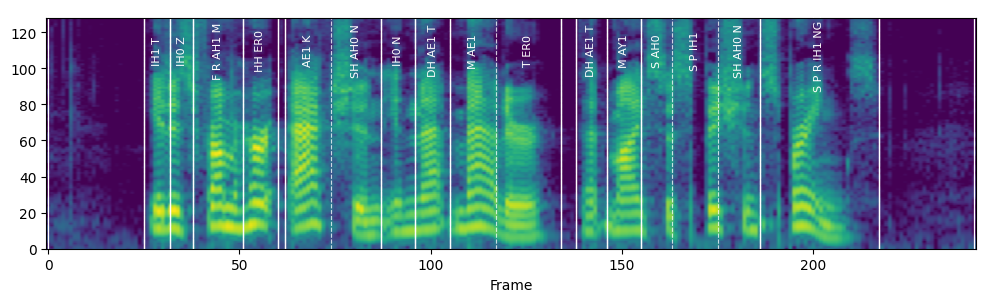

In [16]:
# Loading the waveform

import torchaudio
import torch
import matplotlib.pyplot as plt

waveform, sr = torchaudio.load(str(waveform_path))
waveform = waveform.to("cuda")
waveform = torch.nn.functional.pad(waveform, ((400 - 320) // 2, (400 - 320) // 2))

plot_segmentation(waveform, tg, peaks=None, norms=None, norms_smooth=None)


In [18]:
# Feature extraction function
from torchaudio import pipelines
import torch.nn.functional as F

def extract_features(waveform, sr, model_name, layer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if model_name == "wavlm-large":
        model = pipelines.WAVLM_LARGE.get_model().to(device)
        sr = pipelines.WAVLM_LARGE._sample_rate
        

    elif model_name == "hubert-large":
        model = pipelines.HUBERT_LARGE.get_model().to(device)
        model_sr = pipelines.HUBERT_LARGE._sample_rate

    elif model_name == "hubert-base":
        model = pipelines.HUBERT_BASE.get_model().to(device)
        model_sr = pipelines.HUBERT_BASE._sample_rate

    elif model_name == "wavlm-base":
        model = pipelines.WAVLM_BASE.get_model().to(device)
        model_sr = pipelines.WAVLM_BASE._sample_rate

    elif model_name == "hubert-soft":
        model = torch.hub.load("bshall/hubert:main", "hubert_soft", trust_repo=True).to(device)
        model_sr = 16_000
    else:
        raise ValueError(f"No model found for {model_name}")
    
    waveform = torchaudio.functional.resample(waveform, sr, model_sr)

    layer = int(layer)

    if model_name == "hubert-soft":
        if device.type == "cuda":
            waveform = waveform.unsqueeze(0).cuda()
        else:
            waveform = waveform.unsqueeze(0)
        waveform = F.pad(waveform, ((400 - 320) // 2, (400 - 320) // 2))
        
        with torch.inference_mode():
            outputs, _ = model.encode(waveform, layer=layer)
            encoding = outputs[0].cpu().numpy()

    else:
        waveform = waveform.to(device)
        waveform = F.pad(waveform, ((400 - 320) // 2, (400 - 320) // 2))

        with torch.inference_mode():
            outputs, _ = model.extract_features(waveform)
            encoding = outputs[layer - 1].squeeze(0).cpu().numpy()
    
    return encoding

feat = extract_features(waveform, sr, model_name="hubert-soft", layer=9)
print("Feature shape:", feat.shape)


Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main


Feature shape: (242, 768)


Number of peaks detected: 15


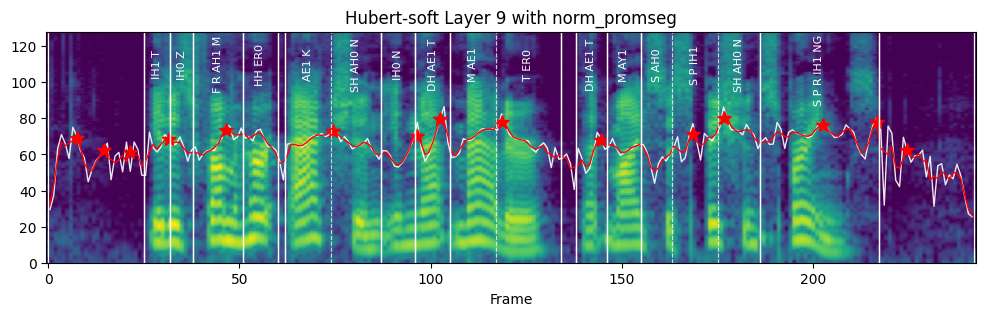

In [ ]:
# Norm method
from scipy.signal import find_peaks

def norm_promseg(feat, window_size, prominence):
    norm = np.linalg.norm(feat, axis=1)
    mu, std = np.mean(norm), np.std(norm)
    norm_z = (norm - mu) / std
    kernel = np.ones(window_size) / window_size
    pad = window_size // 2
    norm_smooth = np.convolve(np.pad(norm_z, (pad, pad), mode='edge'), kernel, mode='valid')
    peaks, _ = find_peaks(norm_smooth, prominence=prominence)
    return norm_z, norm_smooth, peaks

norms, norms_smooth, peaks = norm_promseg(feat, window_size=3, prominence=0.5)
print("Number of peaks detected:", len(peaks))
plot_segmentation(
    waveform, 
    tg,
    peaks=peaks,
    norms=norms,
    norms_smooth=norms_smooth,
    title="Hubert-soft Layer 9 with norm_promseg"
)
listen_to_segmentation(waveform_path, peaks)

Number of peaks detected: 22


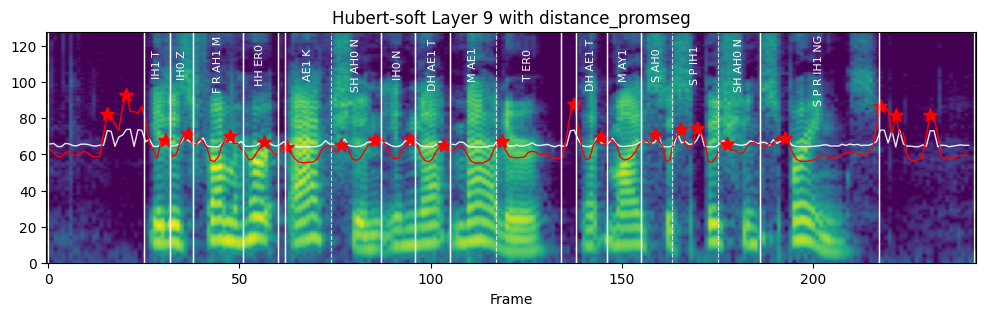

In [25]:
#  Distance method
from scipy.spatial.distance import cosine
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler

def distance_promseg(feat, window_size, prominence):
    feat_norm = StandardScaler().fit_transform(feat)
    distances = np.array([
        cosine(feat_norm[i], feat_norm[i + 1]) 
        for i in range(len(feat_norm) - 1)
    ])
    distances_norm = StandardScaler().fit_transform(distances.reshape(-1, 1)).flatten()
    kernel = np.ones(window_size) / window_size
    pad = window_size // 2
    distances_smooth = np.convolve(np.pad(distances_norm, (pad, pad), mode='edge'), kernel, mode='valid')
    peaks, _ = find_peaks(distances_smooth, prominence=prominence)
    return distances, distances_smooth, peaks

distances, distances_smooth, peaks = distance_promseg(feat, window_size=3, prominence=0.45)
print("Number of peaks detected:", len(peaks))
plot_segmentation(
    waveform, 
    tg,
    peaks=peaks,
    norms=distances,
    norms_smooth=distances_smooth,
    title="Hubert-soft Layer 9 with distance_promseg"
)
listen_to_segmentation(waveform_path, peaks)